# Drop Features with High PSI Value

In this notebook, we try to showcase all the possible ways in which the DropHighPSIFeatures feature selection class from Feature-engine can be used.

### Dataset

We use the Credit Approval data set from the UCI Machine Learning Repository.

To download the Credit Approval dataset from the UCI Machine Learning Repository visit [this website](http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/) and click on crx.data to download data. Save crx.data to the parent folder of this notebook folder.

**Citation:**

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Data preparation

We will edit some of the original variables and add some additional features to make the possible scenarios more realistic.

In [85]:
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.selection import DropHighPSIFeatures

### Load the data

In [68]:
# load data
data = pd.read_csv('../crx.data', header=None)

# add variable names according to UCI Machine Learning
# Repo information
data.columns = ['A'+str(s) for s in range(1,17)]

# replace ? by np.nan
data = data.replace('?', np.nan)

# re-cast some variables to the correct types 
data['A2'] = data['A2'].astype('float')
data['A14'] = data['A14'].astype('float')

# encode target to binary
data['A16'] = data['A16'].map({'+':1, '-':0})

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


### Edit and add features

In [69]:
# simulate customers from different portfolios.
data['A13'] = data['A13'].map({'g':'portfolio_1', 's':'portfolio_2', 'q':'portfolio_3'})
data['A13'].fillna('Missing', inplace=True)

# simulate customers from different channels
data['A12'] = data['A12'].map({'f':'wholesale', 't':'retail'})
data['A12'].fillna('Missing', inplace=True)


In [72]:
data['A6'].fillna('Missing', inplace=True)

labels = {
'w': '20-25',
'q': '25-30',
'm': '30-35',
'r': '35-40',
'cc': '40-45',
'k': '45-50',
'c': '50-55',
'd': '55-60',
'x': '60-65',
'i': '65-70',
'e': '70-75',
'aa': '75-80',
'ff': '85-90',
'j': 'Unknown',
'Missing': 'Missing',
}
    
data['A6'] = data['A6'].map(labels)

In [73]:
data['time'] = pd.date_range(start='1/1/2018', periods=len(data))

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,time
0,b,30.83,0.000,u,g,NaN,v,1.25,t,t,1,wholesale,portfolio_1,202.0,0,1,2018-01-01
1,a,58.67,4.460,u,g,NaN,h,3.04,t,t,6,wholesale,portfolio_1,43.0,560,1,2018-01-02
2,a,24.50,0.500,u,g,NaN,h,1.50,t,f,0,wholesale,portfolio_1,280.0,824,1,2018-01-03
3,b,27.83,1.540,u,g,NaN,v,3.75,t,t,5,retail,portfolio_1,100.0,3,1,2018-01-04
4,b,20.17,5.625,u,g,NaN,v,1.71,t,f,0,wholesale,portfolio_2,120.0,0,1,2018-01-05


## Data Analysis

In [9]:
# categorical variables

vars_cat = data.select_dtypes(include='O').columns.to_list()

vars_cat

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

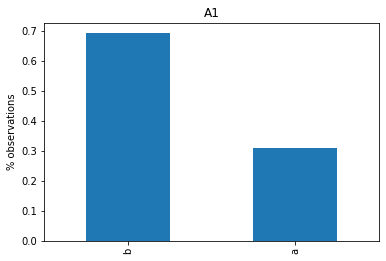

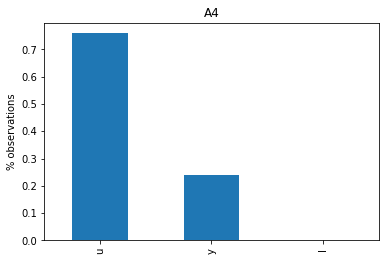

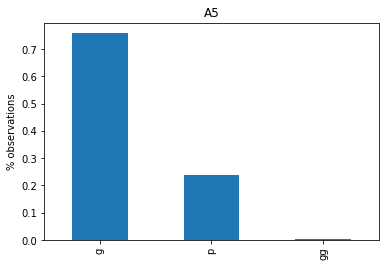

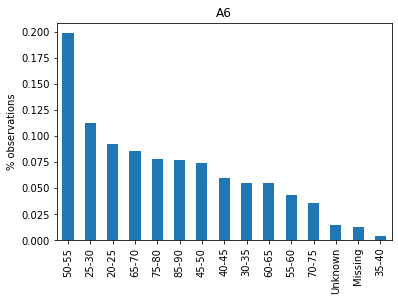

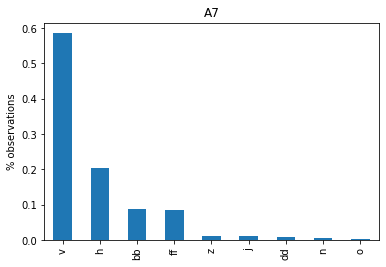

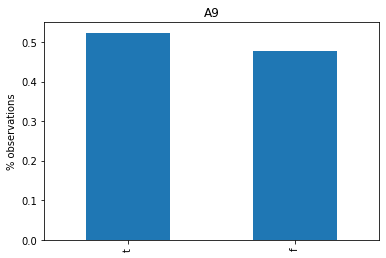

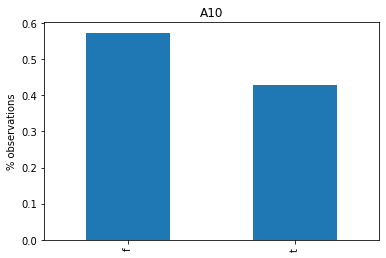

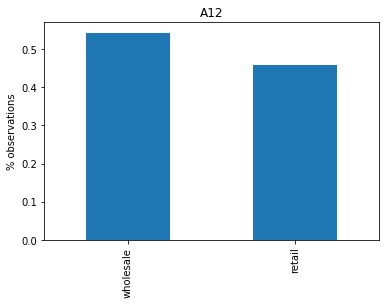

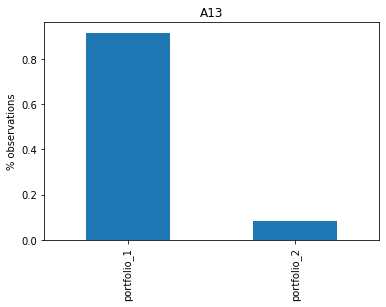

In [10]:
for var in vars_cat:
    data[var].value_counts(normalize=True).plot.bar()
    plt.title(var)
    plt.ylabel('% observations')
    plt.show()

In [11]:
# numerical variables

vars_num = data.select_dtypes(exclude='O').columns.to_list()

vars_num.remove('A16')

vars_num.remove('time')

vars_num

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

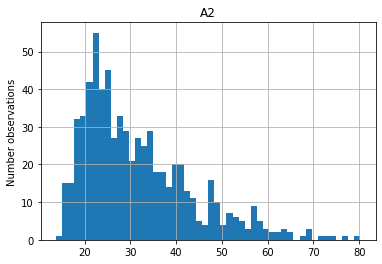

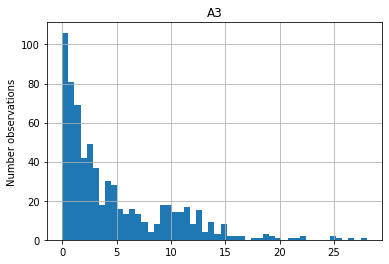

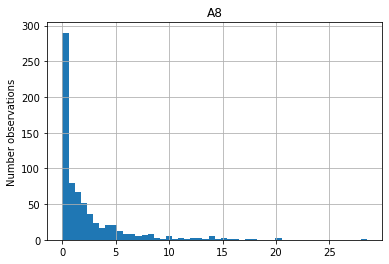

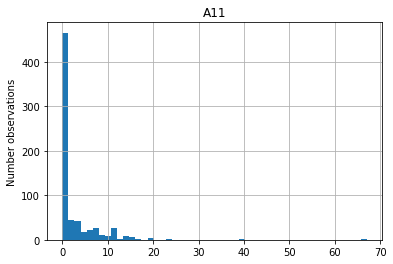

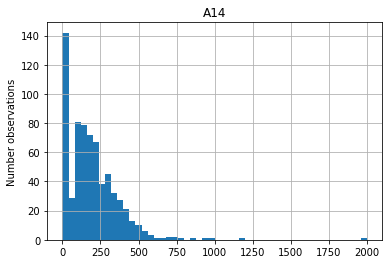

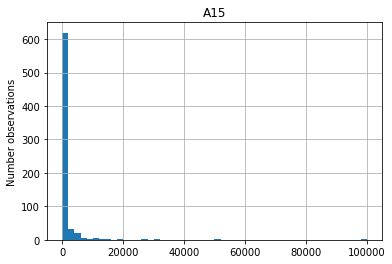

In [12]:
for var in vars_num:
    data[var].hist(bins=50)
    plt.title(var)
    plt.ylabel('Number observations')
    plt.show()

In [21]:
data['A6'].isnull().sum()

0

## Split data based on proportions

In this case, we want to divide the dataset based on proportion of observations. In this example we want to have 60% of observations in the base dataset.

In this situation, using the index is a suitable option.

Be mindful that the split is based on the ordered variable. Smaller values of the variable will be in the reference dataset, and bigger values of the variable will go to the comparison dataset.

In [14]:
transformer = DropHighPSIFeatures(
    split_frac=0.6, # the proportion of obs in the base dataset
    split_col=None, # If None, it uses the index
    strategy = 'equal_frequency', # whether to create the bins of equal frequency
    threshold=0.1, # the PSI threshold to drop variables
    variables=vars_num, # the variables to analyse
    missing_values='ignore',
)

transformer.fit(data)

DropHighPSIFeatures(missing_values='ignore', split_frac=0.6, threshold=0.1,
                    variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [15]:
# the value in the index that determines the separation
# into base and reference datasets. Observations which
# index is smaller than the cut_off will be in the base
# dataset. The remaining ones in the comparison data

transformer.cut_off_

413.4

In [16]:
# the PSI threshold above which variables 
# will be removed

transformer.threshold

0.1

In [17]:
# The PSI value for each analysed variable

transformer.psi_values_

{'A2': 0.05551289799912474,
 'A3': 0.10411556777538997,
 'A8': 0.17825989623109845,
 'A11': 0.04452316620703199,
 'A14': 0.04948425017759906,
 'A15': 0.037154985742040535}

In [18]:
# The variables that will be dropped

transformer.features_to_drop_

['A3', 'A8']

Text(0.5, 1.0, 'A3 has medium high PSI')

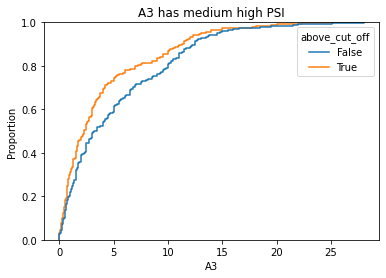

In [19]:
# Let's plot the variables distribution
# in each of the dataset portions

# add a column flagging to which df each observation
# was assigned by the transformer
data['above_cut_off'] = data.index > transformer.cut_off_

# plot
sns.ecdfplot(data=data, x='A3', hue='above_cut_off')
plt.title('A3 has medium high PSI')

Text(0.5, 1.0, 'A2 has low PSI')

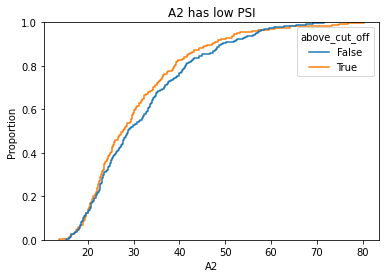

In [20]:
sns.ecdfplot(data=data, x='A2', hue='above_cut_off')
plt.title('A2 has low PSI')

We see that the cumulative distribution of A3 is different in both datasets and this is why it is flagged for removal. On the other hand, the cumulative distribution of A2 is not different in the datasets.

## Split data based on categorical values

This is useful when for example we have customers coming from different portfolios, or we can split datasets based on customer IDs. 

Here, we will simulate customers coming from different age groups. And we want to know if the variable distribution in younger age groups differ from older age groups.

In [46]:
transformer = DropHighPSIFeatures(
    split_frac=0.5,
    split_col='A6',
    strategy = 'equal_frequency',
    threshold=0.1,
    variables=vars_num,
    missing_values='ignore',
)

transformer.fit(data)

DropHighPSIFeatures(missing_values='ignore', split_col='A6', threshold=0.1,
                    variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [47]:
transformer.cut_off_

'50-55'

In [48]:
transformer.psi_values_

{'A2': 0.11125448945416341,
 'A3': 0.06549684510659029,
 'A8': 0.3230376768867264,
 'A11': 0.05410217903415164,
 'A14': 0.07476304063170292,
 'A15': 0.021424363845996122}

In [49]:
transformer.features_to_drop_

['A2', 'A8']

<AxesSubplot:xlabel='A8', ylabel='Proportion'>

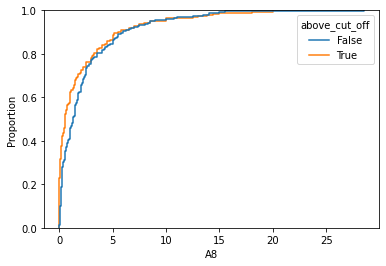

In [50]:
data['above_cut_off'] = data['A6'] > transformer.cut_off_

sns.ecdfplot(data=data, x='A8', hue='above_cut_off')

<AxesSubplot:xlabel='A3', ylabel='Proportion'>

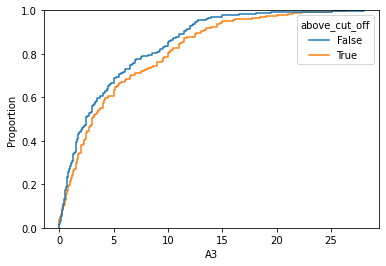

In [51]:
data['above_cut_off'] = data['A6'] > transformer.cut_off_

sns.ecdfplot(data=data, x='A3', hue='above_cut_off')

In [52]:
data[data['above_cut_off']]['A6'].unique()

array(['55-60', '60-65', '65-70', '70-75', '75-80', '85-90', 'Unknown',
       'Missing'], dtype=object)

In [53]:
data[data['above_cut_off']]['A6'].nunique()

8

In [54]:
data[data['above_cut_off']].shape[0]

278

In [55]:
data[~data['above_cut_off']]['A6'].unique()

array(['20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55'],
      dtype=object)

In [56]:
data[~data['above_cut_off']]['A6'].nunique()

7

In [57]:
data[~data['above_cut_off']].shape[0]

412

## Split data based on distinct values

In [58]:
transformer = DropHighPSIFeatures(
    split_frac=0.5,
    split_distinct=True,
    split_col='A6',
    strategy = 'equal_frequency',
    threshold=0.1,
    variables=vars_num,
    missing_values='ignore',
)

transformer.fit(data)

DropHighPSIFeatures(missing_values='ignore', split_col='A6',
                    split_distinct=True, threshold=0.1,
                    variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [59]:
transformer.cut_off_

'55-60'

In [60]:
transformer.psi_values_

{'A2': 0.14147083636315627,
 'A3': 0.08525428107837303,
 'A8': 0.38235921772107956,
 'A11': 0.0366283178530446,
 'A14': 0.08538069269690633,
 'A15': 0.008015790788329747}

In [61]:
transformer.features_to_drop_

['A2', 'A8']

<AxesSubplot:xlabel='A2', ylabel='Proportion'>

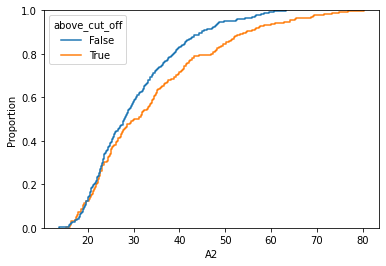

In [62]:
data['above_cut_off'] = data['A6'] > transformer.cut_off_

sns.ecdfplot(data=data, x='A2', hue='above_cut_off')

In [63]:
data[data['above_cut_off']]['A6'].nunique()

7

In [64]:
data[~data['above_cut_off']]['A6'].nunique()

8

In [65]:
data[data['above_cut_off']].shape[0], data[~data['above_cut_off']].shape[0]

(248, 442)

## Split based on selected labels

In [74]:
transformer = DropHighPSIFeatures(
    cut_off=['portfolio_2', 'portfolio_3'],
    split_distinct=True,
    split_col='A13',
    strategy = 'equal_frequency',
    threshold=0.1,
    variables=vars_num,
    missing_values='ignore',
)

transformer.fit(data)

DropHighPSIFeatures(cut_off=['portfolio_2', 'portfolio_3'],
                    missing_values='ignore', split_col='A13',
                    split_distinct=True, threshold=0.1,
                    variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [75]:
transformer.cut_off_

['portfolio_2', 'portfolio_3']

In [76]:
transformer.psi_values_

{'A2': 0.1701957001921069,
 'A3': 0.36194679926553797,
 'A8': 0.11568886281984345,
 'A11': 0.0,
 'A14': 0.16574343098156213,
 'A15': 0.0}

In [77]:
transformer.features_to_drop_

['A2', 'A3', 'A8', 'A14']

<AxesSubplot:xlabel='A3', ylabel='Proportion'>

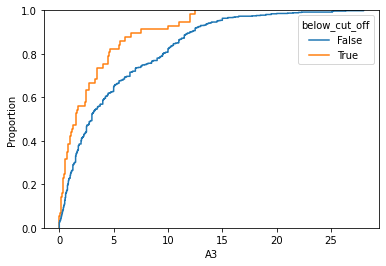

In [80]:
data['below_cut_off'] = data['A13'].isin(transformer.cut_off_)

sns.ecdfplot(data=data, x='A3', hue='below_cut_off')

<AxesSubplot:xlabel='A11', ylabel='Proportion'>

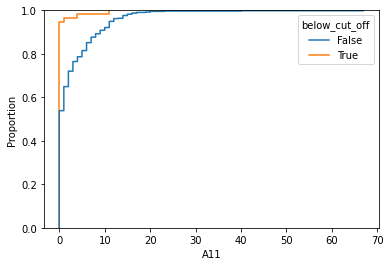

In [81]:
sns.ecdfplot(data=data, x='A11', hue='below_cut_off')

## Split based on Date

If our data had a valid timestamp, we could want to compare the distributions before and after a time point.

In [83]:
data['time'].agg(['min', 'max'])

min   2018-01-01
max   2019-11-21
Name: time, dtype: datetime64[ns]

In [92]:
transformer = DropHighPSIFeatures(
    cut_off=pd.tp_(2018, 12, 14),
    split_distinct=True,
    split_col='A13',
    strategy = 'equal_frequency',
    threshold=0.1,
    variables=vars_num,
    missing_values='ignore',
)

transformer.fit(data)

AssertionError: 